# Summary
This notebook is used to evaluate CTPN text detection, which can be built from here:
<br>
https://github.com/eragonruan/text-detection-ctpn

# Imports

In [1]:
import os

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# To parse coco annot
import coco_text
# To eval prediction json 
import coco_evaluation
# For plotting stuff
from util import plotting as uplt

# Constants

In [4]:
# Cocotext annotation data, can be downloaded here: https://s3.amazonaws.com/cocotext/COCO_Text.zip
GROUND_TRUTH_PATH = r'/home/rudi/Documents/Data/cocotext/COCO_Text.json'
# Bounding box annotations generated by CTPN, each record containing: 
# image id
# bounding box [top left x, top left y, width, height]
# confidence score
EVAL_PATH = r'/home/rudi/Documents/Data/cocotext/cocotext_ctpn_output_score.json'
# To compare the bounding box if needed
IMAGES_DIR = r'/home/rudi/Documents/Data/cocotext/train2014_text_valid'

# Initialization

In [5]:
# Ground truth annotations
gt = coco_text.COCO_Text(GROUND_TRUTH_PATH)

loading annotations into memory...
0:00:01.771097
creating index...
index created!


In [6]:
gt.info()

url: http://vision.cornell.edu/se3/coco-text/
date_created: 2017-03-28
version: 1.4
description: This is 1.4 version of the 2017 COCO-Text dataset.
author: COCO-Text group


In [7]:
# Evaluated predictions
ev = gt.loadRes(EVAL_PATH)

Loading and preparing results...     
DONE (t=9.53s)


In [8]:
# Get the list of annotation and image ids with certain filter
# Default used for comparison: legible text, machine printed (screw handwriting)
valid_image_ids = gt.getImgIds(imgIds=gt.train, 
                    catIds=[('legibility','legible'),('class','machine printed')])
valid_annotation_ids = gt.getAnnIds(imgIds=gt.train, 
                        catIds=[('legibility','legible'),('class','machine printed')])

In [9]:
# Build a dictionary of image IDs to their filepath
# For visualisation and other misc stuff
image_paths = {}
for image_name in os.listdir(IMAGES_DIR):
    image_id = int(image_name.split('.')[0].split('_')[-1])
    image_paths[image_id] = os.path.join(IMAGES_DIR,image_name)

# Main

In [10]:
# Sample annotation comparison
image_id = 81

gt_ann = gt.loadAnns(gt.getAnnIds(imgIds=image_id))
eval_ann = ev.loadAnns(ev.getAnnIds(imgIds=image_id))

print('Ground truth box of image '+str(image_id))
print(gt_ann[0]['bbox'])
print('\nEvaluated box of image '+str(image_id))
print(eval_ann[0]['bbox'])
print('\nIOU: '+str(coco_evaluation.iou_score(gt_ann[0]['bbox'], eval_ann[0]['bbox'])))

Ground truth box of image 81
[101, 173, 127.8800759193141, 18.483669688596507]

Evaluated box of image 81
[90, 175, 147, 19]

IOU: 0.6914066132540398


## Base Evaluation
Using the provided evaluation script, tracking the TP/FP/FN predictions
* TP: The prediction bounding box matches (IOU higher than a certain threshold) a ground truth bounding box that has yet been matched in an image  
* FP: The prediction bounding box does not match (IOU lower than a certain threshold) any ground truth bounding boxes that have yet been matched in an image
* FN: The ground truth bounding box is not matched by any prediction bounding boxes

In [19]:
# Base built-in evaluation
IOU_THRESHOLD = 0.5
detection_results = coco_evaluation.getDetections(gt,ev,
                                                  imgIds=valid_image_ids,
                                                  annIds=valid_annotation_ids,
                                                  detection_threshold=IOU_THRESHOLD)

print(f"IOU threshold {IOU_THRESHOLD}")
print(f"True positive count : {len(detection_results['true_positives'])}")
print(f"False positive count : {len(detection_results['false_positives'])}")
print(f"False negative count : {len(detection_results['false_negatives'])}")

IOU threshold 0.5
True positive count : 12656
False positive count : 54123
False negative count : 53064


### Note
The result is understandably bad due to the way CTPN works vs the ground truth, the former generates one bounding box per line of text instead of word/token like the latter.
<br>
As an example, given there is a text: 'this is a watermark' at the bottom of an image:
<br>
CTPN will generate one bounding box that captures the whole line.
<br>
While in ground truth it would be annotated as 4 separate boxes.

## In-Depth Base Evaluation

Start by plotting the bounding boxes size statistics of each TP/FP/FN group

### Bounding Box Area

In [35]:
from scipy.stats import describe

tp_areas_list = []
fp_areas_list = []
fn_areas_list = []

for tp_det in detection_results['true_positives']:
    annot = ev.loadAnns(tp_det['eval_id'])
    tp_areas_list.append(annot[0]['area'])
    
for fp_det in detection_results['false_positives']:
    annot = ev.loadAnns(fp_det['eval_id'])
    fp_areas_list.append(annot[0]['area'])

for fn_det in detection_results['false_negatives']:
    annot = gt.loadAnns(fn_det['gt_id'])
    fn_areas_list.append(annot[0]['area'])
    
tp_areas_list = np.array(tp_areas_list)
fp_areas_list = np.array(fp_areas_list)
fn_areas_list = np.array(fn_areas_list)

print("TP describe stats")
print(describe(tp_areas_list))
print()

print("FP describe stats")
print(describe(fp_areas_list))
print()

print("FN describe stats")
print(describe(fn_areas_list))
print()

TP describe stats
DescribeResult(nobs=12656, minmax=(138, 109120), mean=3125.2780499367886, variance=29375605.578549366, skewness=6.188193047913723, kurtosis=60.44565046299618)

FP describe stats
DescribeResult(nobs=54123, minmax=(64, 178112), mean=1799.4653474493284, variance=15995712.621110808, skewness=12.045963673610345, kurtosis=262.98420214035076)

FN describe stats
DescribeResult(nobs=53064, minmax=(0.0, 144479.11224269206), mean=1106.838259553064, variance=10106494.476544034, skewness=15.498271438045903, kurtosis=397.58538144983083)



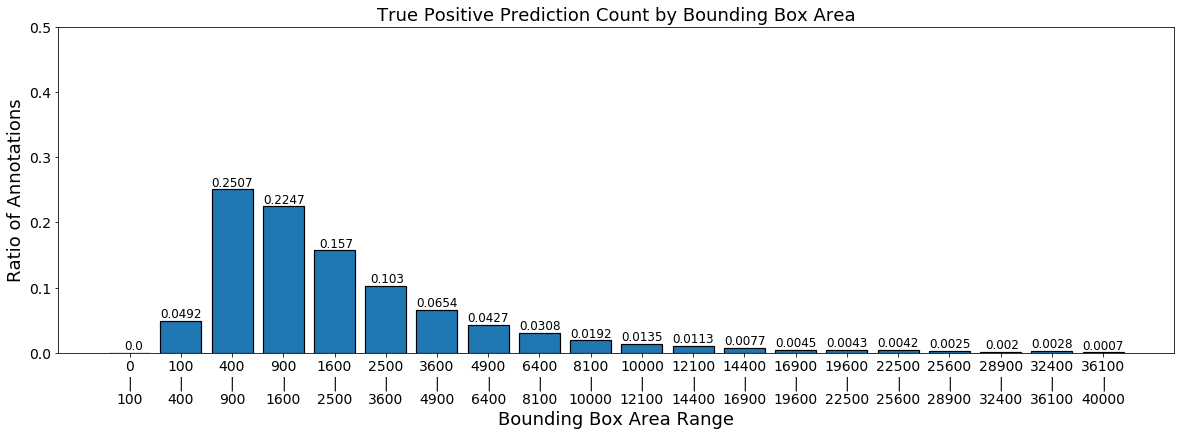

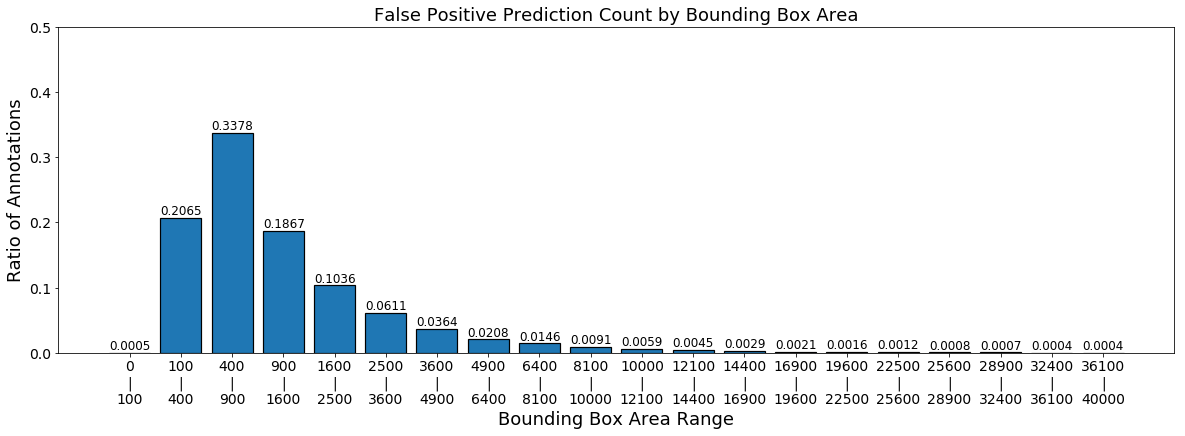

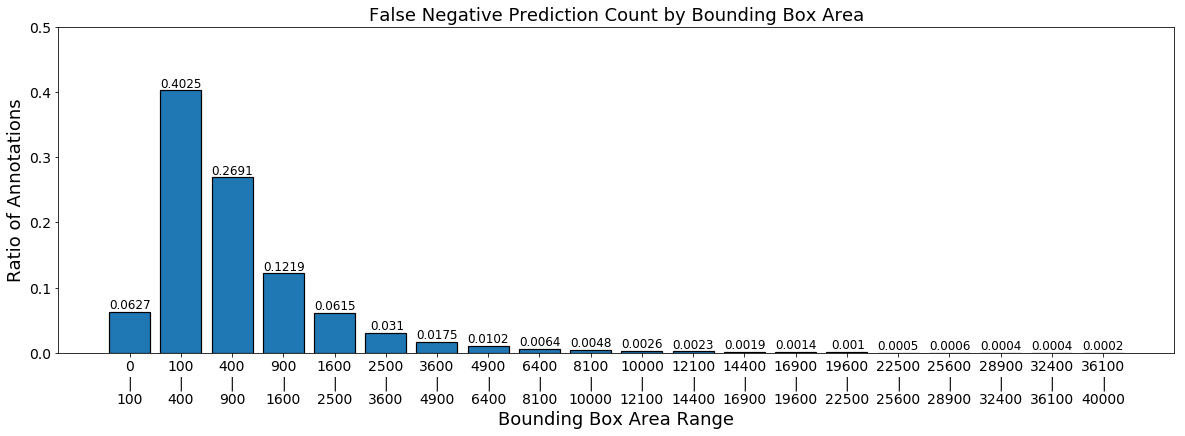

In [151]:
from matplotlib.pyplot import hist

bin_range = np.power(np.linspace(0,200,21),2).astype(np.int64)
tp_num_annots = np.histogram(tp_areas_list,bin_range)[0] / len(tp_areas_list)
fp_num_annots = np.histogram(fp_areas_list,bin_range)[0] / len(fp_areas_list)
fn_num_annots = np.histogram(fn_areas_list,bin_range)[0] / len(fn_areas_list)
bin_label = [str(bstart) + '\n' + '|\n' + str(bend) for bstart,bend in zip(bin_range[:-1],bin_range[1:])]
uplt.plot_annot_count_bar(np.arange(len(tp_num_annots)), tp_num_annots,
                                x_ticks=bin_label,
                                title='True Positive Prediction Count by Bounding Box Area',
                                xlabel='Bounding Box Area Range',
                                ylabel='Ratio of Annotations',
                                ylim=(0,0.5),
                                figsize=(20,6))
uplt.plot_annot_count_bar(np.arange(len(fp_num_annots)), fp_num_annots,
                                x_ticks=bin_label,
                                title='False Positive Prediction Count by Bounding Box Area',
                                xlabel='Bounding Box Area Range',
                                ylabel='Ratio of Annotations',
                                ylim=(0,0.5),
                                figsize=(20,6))
uplt.plot_annot_count_bar(np.arange(len(fn_num_annots)), fn_num_annots,
                                x_ticks=bin_label,
                                title='False Negative Prediction Count by Bounding Box Area',
                                xlabel='Bounding Box Area Range',
                                ylabel='Ratio of Annotations',
                                ylim=(0,0.5),
                                figsize=(20,6))

### Bounding Box Log Width-Height Ratio

In [154]:
from scipy.stats import describe

eps = 1e-05
tp_whratio_list = []
fp_whratio_list = []
fn_whratio_list = []

for tp_det in detection_results['true_positives']:
    annot = ev.loadAnns(tp_det['eval_id'])
    tp_whratio_list.append(np.log10((annot[0]['bbox'][2] + eps) / 
                                  (annot[0]['bbox'][3] + eps)))
    
for fp_det in detection_results['false_positives']:
    annot = ev.loadAnns(fp_det['eval_id'])
    fp_whratio_list.append(np.log10((annot[0]['bbox'][2] + eps) / 
                                  (annot[0]['bbox'][3] + eps)))

for fn_det in detection_results['false_negatives']:
    annot = gt.loadAnns(fn_det['gt_id'])
    fn_whratio_list.append(np.log10((annot[0]['bbox'][2] + eps) / 
                                  (annot[0]['bbox'][3] + eps)))
    
tp_whratio_list = np.array(tp_whratio_list)
fp_whratio_list = np.array(fp_whratio_list)
fn_whratio_list = np.array(fn_whratio_list)

print("TP wh ratio describe stats")
print(describe(tp_whratio_list))
print()

print("FP wh ratio describe stats")
print(describe(fp_whratio_list))
print()

print("FN wh ratio describe stats")
print(describe(fn_whratio_list))
print()

TP wh ratio describe stats
DescribeResult(nobs=12656, minmax=(-0.3052670056159742, 1.3812741417802477), mean=0.4422214231763283, variance=0.05988233465665289, skewness=-0.18730950776458877, kurtosis=0.11436155667203973)

FP wh ratio describe stats
DescribeResult(nobs=54123, minmax=(-0.3296750721100448, 1.8930208777679165), mean=0.5595069920866373, variance=0.08437396024188519, skewness=-0.05405615923702515, kurtosis=0.24532060264163302)

FN wh ratio describe stats
DescribeResult(nobs=53064, minmax=(-6.258246682456884, 6.4306405058192295), mean=0.22343709796461922, variance=0.08147301486936516, skewness=0.15558728749864037, kurtosis=18.772569281454405)



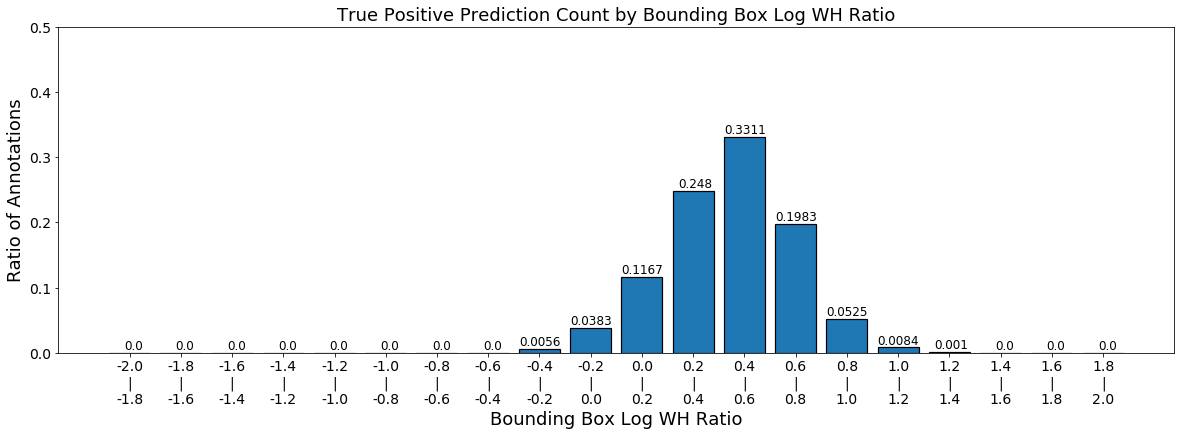

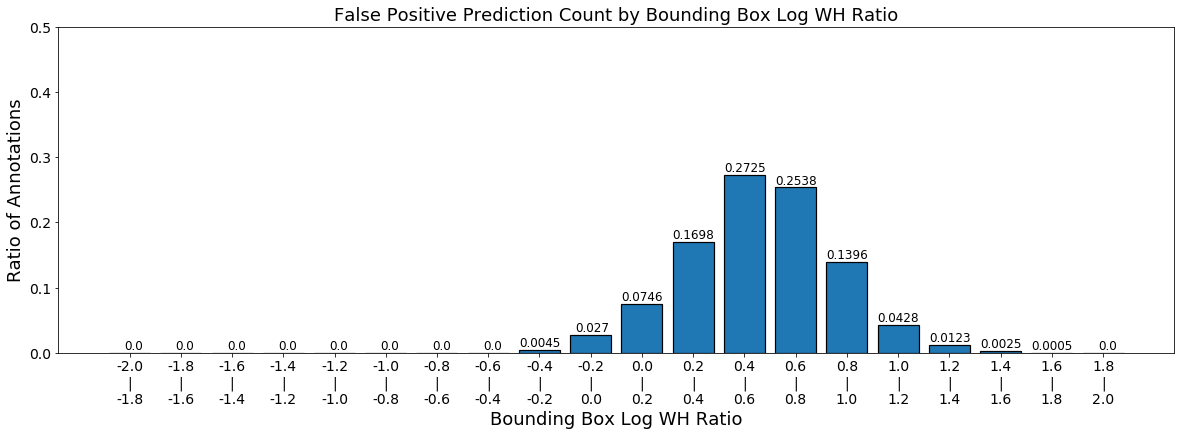

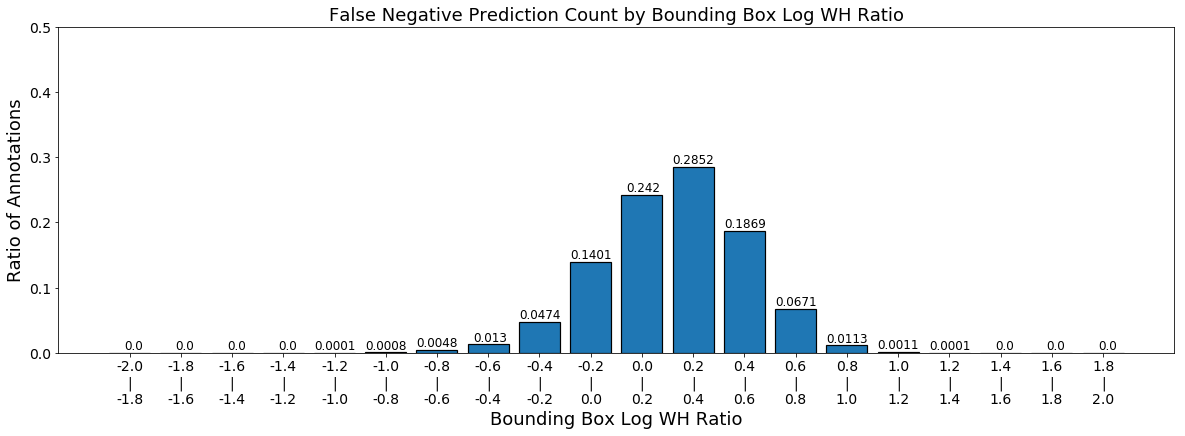

In [159]:
from matplotlib.pyplot import hist

bin_range = np.linspace(-2,2,21)
tp_num_annots = np.histogram(tp_whratio_list,bin_range)[0] / len(tp_whratio_list)
fp_num_annots = np.histogram(fp_whratio_list,bin_range)[0] / len(fp_whratio_list)
fn_num_annots = np.histogram(fn_whratio_list,bin_range)[0] / len(fn_whratio_list)
bin_label = [str(round(bstart,1)) + '\n' + '|\n' + str(round(bend,2)) for bstart,bend in zip(bin_range[:-1],bin_range[1:])]
uplt.plot_annot_count_bar(np.arange(len(tp_num_annots)), tp_num_annots,
                                x_ticks=bin_label,
                                title='True Positive Prediction Count by Bounding Box Log WH Ratio',
                                xlabel='Bounding Box Log WH Ratio',
                                ylabel='Ratio of Annotations',
                                ylim=(0,0.5),
                                figsize=(20,6))
uplt.plot_annot_count_bar(np.arange(len(fp_num_annots)), fp_num_annots,
                                x_ticks=bin_label,
                                title='False Positive Prediction Count by Bounding Box Log WH Ratio',
                                xlabel='Bounding Box Log WH Ratio',
                                ylabel='Ratio of Annotations',
                                ylim=(0,0.5),
                                figsize=(20,6))
uplt.plot_annot_count_bar(np.arange(len(fn_num_annots)), fn_num_annots,
                                x_ticks=bin_label,
                                title='False Negative Prediction Count by Bounding Box Log WH Ratio',
                                xlabel='Bounding Box Log WH Ratio',
                                ylabel='Ratio of Annotations',
                                ylim=(0,0.5),
                                figsize=(20,6))

## Advanced Evaluation

In [18]:
gt_ann = gt.loadAnns(gt.getAnnIds(imgIds=valid_image_ids[5]))
print(gt_ann)

[{'polygon': [83.37613326716314, 384.7755886270737, 108.31706836284278, 384.7755886270737, 108.31706836284278, 407.62754106282364, 83.37613326716314, 407.62754106282364], 'language': 'english', 'area': 569.9490625095963, 'id': 1238380, 'utf8_string': 'T.', 'image_id': 458762, 'bbox': [83.37613326716314, 384.7755886270737, 24.940935095679627, 22.8519524357499], 'legibility': 'legible', 'class': 'machine printed'}, {'polygon': [4.990337252170054, 385.61419238618384, 84.42407171656146, 385.61419238618384, 84.42407171656146, 407.83719200260117, 4.990337252170054, 407.83719200260117], 'language': 'english', 'area': 1765.2558505327665, 'id': 1238381, 'utf8_string': 'Paulina', 'image_id': 458762, 'bbox': [4.990337252170054, 385.61419238618384, 79.4337344643914, 22.222999616417333], 'legibility': 'legible', 'class': 'machine printed'}, {'polygon': [20.080650923505626, 406.57928636393603, 91.75964086234957, 406.57928636393603, 91.75964086234957, 413.7074183163718, 20.080650923505626, 413.707418

In [150]:
from importlib import reload 
reload(uplt)

<module 'util.plotting' from '/home/rudi/Documents/Notebook/Data_Anal/cocotext_analysis/util/plotting.py'>